In [12]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf 
from tensorflow import keras 
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import MetaTrader5 as mt5

In [13]:
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

path=os.path.join(mt5.terminal_info().data_path,r'MQL5\Files')
mt5.shutdown()
filename = os.path.join(path,'study_pricedelt_data.csv')
data = np.asarray( pd.read_table(filename,
                   sep=',',
                   header=None,
                   skipinitialspace=True,
                   encoding='utf-8',
                   float_precision='high',
                   dtype=np.float64,
                   low_memory=False))

In [14]:
inputs=data.shape[1]-3
targerts=3
train_data=data[:,0:inputs]
train_target=data[:,inputs:]

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

# Add the LSTM block to the model
model1 = keras.Sequential([keras.layers.InputLayer(input_shape=inputs),
                           # Reformat tensor to a 3-dimensional one. Specify 2 dimensions as 3rd one is defined by batch size
                           keras.layers.Reshape((-1,2)), 
                           # LSTM block contains 40 elements and returns results at each step  
                           keras.layers.LSTM(40, return_sequences=False, 
                           kernel_regularizer=keras.regularizers.l1_l2(l1=1e-4, l2=1e-3)),
                           keras.layers.Dense(40, activation=tf.nn.tanh, kernel_regularizer=keras.regularizers.l1_l2(l1=1e-4, l2=1e-3)), 
                           keras.layers.Dense(40, activation=tf.nn.tanh, kernel_regularizer=keras.regularizers.l1_l2(l1=1e-4, l2=1e-3)), 
                           keras.layers.Dense(40, activation=tf.nn.tanh, kernel_regularizer=keras.regularizers.l1_l2(l1=1e-4, l2=1e-3)), 
                           keras.layers.Dense(targerts, activation=tf.nn.tanh) 
                         ])
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 2, 2)              0         
                                                                 
 lstm_3 (LSTM)               (None, 40)                6880      
                                                                 
 dense_12 (Dense)            (None, 40)                1640      
                                                                 
 dense_13 (Dense)            (None, 40)                1640      
                                                                 
 dense_14 (Dense)            (None, 40)                1640      
                                                                 
 dense_15 (Dense)            (None, 3)                 123       
                                                                 
Total params: 11,923
Trainable params: 11,923
Non-trai

In [18]:
model1.compile(optimizer='Adam', 
               loss='mean_squared_error', 
               metrics=['accuracy'])
history1 = model1.fit(train_data, train_target,
                      epochs=200, batch_size=500,
                      callbacks=[callback],
                      verbose=2,
                      validation_split=0.5,
                      shuffle=False)

Epoch 1/200
15/15 - 3s - loss: 0.4125 - accuracy: 0.7534 - val_loss: 0.3328 - val_accuracy: 0.7656 - 3s/epoch - 224ms/step
Epoch 2/200
15/15 - 0s - loss: 0.2977 - accuracy: 0.7912 - val_loss: 0.2921 - val_accuracy: 0.7915 - 134ms/epoch - 9ms/step
Epoch 3/200
15/15 - 0s - loss: 0.2788 - accuracy: 0.7978 - val_loss: 0.2758 - val_accuracy: 0.7938 - 157ms/epoch - 10ms/step
Epoch 4/200
15/15 - 0s - loss: 0.2612 - accuracy: 0.8039 - val_loss: 0.2626 - val_accuracy: 0.7984 - 131ms/epoch - 9ms/step
Epoch 5/200
15/15 - 0s - loss: 0.2470 - accuracy: 0.8125 - val_loss: 0.2491 - val_accuracy: 0.7970 - 141ms/epoch - 9ms/step
Epoch 6/200
15/15 - 0s - loss: 0.2336 - accuracy: 0.8130 - val_loss: 0.2365 - val_accuracy: 0.7936 - 157ms/epoch - 10ms/step
Epoch 7/200
15/15 - 0s - loss: 0.2212 - accuracy: 0.8191 - val_loss: 0.2251 - val_accuracy: 0.7935 - 141ms/epoch - 9ms/step
Epoch 8/200
15/15 - 0s - loss: 0.2098 - accuracy: 0.8213 - val_loss: 0.2146 - val_accuracy: 0.7934 - 142ms/epoch - 9ms/step
Epoch 9

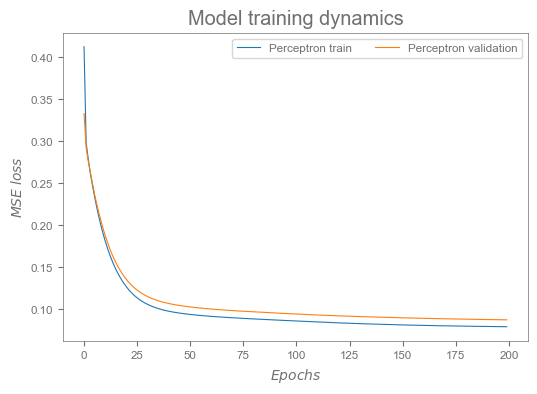

In [19]:
# Add fonts
font_list=fm.findSystemFonts()
for f in font_list:
    if(f.__contains__('ClearSans')):
        fm.fontManager.addfont(f)

# Set parameters for output graphs
mp.rcParams.update({'font.family':'Arial',
                    'font.serif':'Arial',
                    'axes.titlesize': 'x-large',
                    'axes.labelsize':'medium',
                    'xtick.labelsize':'small',
                    'ytick.labelsize':'small',
                    'legend.fontsize':'small',
                    'figure.figsize':[6.0,4.0],
                    'axes.titlecolor': '#707070',
                    'axes.labelcolor': '#707070',
                    'axes.edgecolor': '#707070',
                    'xtick.labelcolor': '#707070',
                    'ytick.labelcolor': '#707070',
                    'xtick.color': '#707070',
                    'ytick.color': '#707070',
                    'text.color': '#707070',
                    'lines.linewidth': 0.8,
                    'axes.linewidth': 0.5
                   })
# Render model training results
plt.figure()
plt.plot(history1.history['loss'], label='Perceptron train')
plt.plot(history1.history['val_loss'], label='Perceptron validation')
plt.ylabel('$MSE$ $loss$')
plt.xlabel('$Epochs$')
plt.title('Model training dynamics')
plt.legend(loc='upper right', ncol=2)

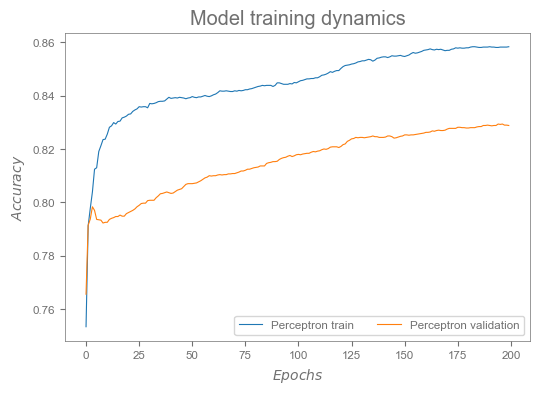

In [20]:
plt.figure()
plt.plot(history1.history['accuracy'], label='Perceptron train')
plt.plot(history1.history['val_accuracy'], label='Perceptron validation')
plt.ylabel('$Accuracy$')
plt.xlabel('$Epochs$')
plt.title('Model training dynamics')
plt.legend(loc='lower right', ncol=2)

In [21]:
# Load testing dataset
test_filename = os.path.join(path,'test_pricedelt_data.csv')
test = np.asarray( pd.read_table(test_filename,
                   sep=',',
                   header=None,
                   skipinitialspace=True,
                   encoding='utf-8',
                   float_precision='high',
                   dtype=np.float64,
                   low_memory=False))
# Split test dataset to input data and target
test_data=test[:,0:inputs]
test_target=test[:,inputs:]

# Check model results on a test dataset
test_loss1, test_acc1 = model1.evaluate(test_data, test_target, verbose=2) 

25/25 - 0s - loss: 0.0792 - accuracy: 0.8481 - 94ms/epoch - 4ms/step


25/25 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'predict results model1')

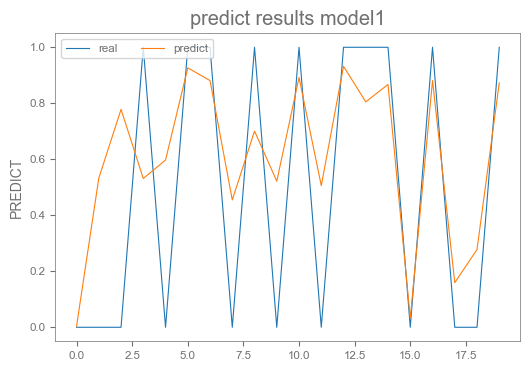

In [22]:
mm=model1.predict(test_data)
rr = {}
rr=pd.DataFrame(rr)
test_target = pd.DataFrame(test_target)
mm = pd.DataFrame(mm)
rr['real'] = test_target[1]
rr['predict'] = mm[1]
rs = rr.head(20)
#rs = rr

plt.figure()
plt.plot(rs['real'], label='real')
plt.plot(rs['predict'], label='predict')
plt.legend(loc='upper left',ncol=2)
plt.ylabel('PREDICT')
plt.title('predict results model1')


In [23]:
import socket

class socketserver(object):
    def __init__(self, address, port):
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.address = address
        self.port = port
        self.sock.bind((self.address, self.port))
        
    def socket_receive(self):
        self.sock.listen(1)
        self.conn, self.addr = self.sock.accept()
        self.cummdata = ''

        while True:
            data = self.conn.recv(10000)
            self.cummdata+=data.decode("utf-8")
            if not data:
                self.conn.close()
                break
            return self.cummdata
    
    def socket_send(self, message):
        self.sock.listen(1)
        self.conn, self.addr = self.sock.accept()
        self.conn.send(bytes(message, "utf-8"))
    
            
    def __del__(self):
        self.conn.close()

In [ ]:
import ast

host = 'localhost'
port = 5091 
n_steps = 60
TIMEFRAME = 24 | 0x4000
#model   = Model(n_steps, "EURUSD", TIMEFRAME)

serv = socketserver(host, port)

while True:
        print("<<--Waiting for Prices to Predict-->>")
        rates = pd.DataFrame(ast.literal_eval(serv.socket_receive()))
        rates = rates.rates.pct_change(1)
        rates.dropna(inplace=True)
        rates = rates.values.reshape((1, n_steps))
        serv.socket_send(str(model.predict(rates).flatten()[0]))

Exception ignored in: <function socketserver.__del__ at 0x0000018F9885CD30>
Traceback (most recent call last):
  File "C:\Users\Stepan\AppData\Local\Temp\ipykernel_87012\3024821691.py", line 30, in __del__
AttributeError: 'socketserver' object has no attribute 'conn'


<<--Waiting for Prices to Predict-->>
